0. 필요한 라이브러리 import

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tqdm

# 글자 전처리를 위한 import
import string
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator 

1. 데이터 불러오기

In [3]:
data = pd.read_csv("netflix_reviews.csv")

In [4]:
data

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,5f109900-7485-4333-8317-44251899fc83,Siddiqui Alkasim,Good 😊,5,0,8.137.0 build 4 50942,2024-10-26 13:41:01,8.137.0 build 4 50942
1,68174e16-f4a3-48f8-b0e7-f60840800d71,Binher Bilal,App acha hai lkin isne mere acc se khud paise ...,1,0,8.137.0 build 4 50942,2024-10-26 13:03:47,8.137.0 build 4 50942
2,b95c7685-cf4c-4a13-a8ce-798ec921fc84,Gabriella Guzman,Poop,5,0,8.137.0 build 4 50942,2024-10-26 13:01:15,8.137.0 build 4 50942
3,f3fb3677-8220-439e-8500-403b5378e04e,archie arreola,Poor,1,0,8.137.0 build 4 50942,2024-10-26 13:00:50,8.137.0 build 4 50942
4,45243bcb-120b-4dd4-acfa-9ae16197242e,Mzokhona Mthethwa,It is just the best app you could rely on,5,0,NaN,2024-10-26 12:57:57,NaN
...,...,...,...,...,...,...,...,...
117539,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
117540,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
117541,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
117542,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346


In [5]:
data.columns

Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')

In [6]:
data.shape

(117544, 8)

1-2. 데이터 분포 파악

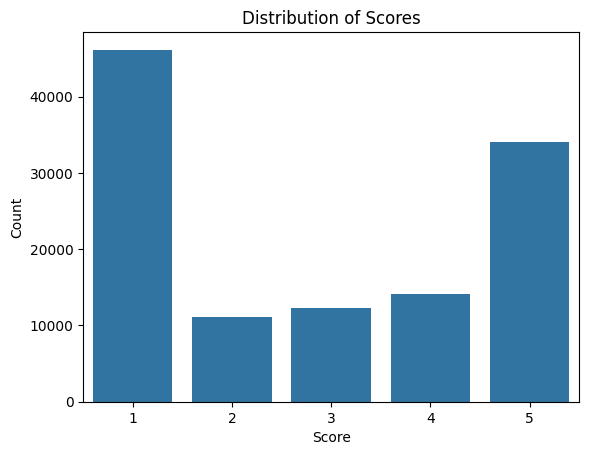

In [8]:
num_of_review=data['score'].value_counts()
import seaborn as sns 
import matplotlib.pyplot as plt  

sns.barplot(x=num_of_review.index, y=num_of_review.values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

2. 텍스트 데이터 전처리

In [9]:
# 전처리 함수
import re

def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text

In [10]:
data["content"] = data["content"].apply(preprocess_text)
data["content"]

0                                                      good
1         app acha hai lkin isne mere acc se khud paise ...
2                                                      poop
3                                                      poor
4                 it is just the best app you could rely on
                                ...                        
117539    i really like it there are so many movies and ...
117540       i love netflix i always enjoy my time using it
117541                 sound quality is very slow of movies
117542    rate is very expensive bcos we see netflix sun...
117543    this app is awesome for english movies series ...
Name: content, Length: 117544, dtype: object

In [11]:
X = data["content"].tolist()
y = data["score"].tolist()

train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(X, y, test_size=0.2, random_state=42)

# 토큰 생성
tokenizer = get_tokenizer('basic_english')

def yield_tokens(sentences):
    for text in sentences:
        yield tokenizer(text)

2-2. 
학습 리뷰 속 단어들로 단어집 생성, 없는 단어는 UNK 처리
파이프라인 구성 
text_pipeline : 문장의 단어 분리화 및 단어의 숫자형 값 반환
lable_pipeline : 평점을 모델링 하기 전 -1 처리 (평점이 1 부터 시작하기 때문)

In [12]:
# 한 문장당 바꿔주는 iterator임
vocab = build_vocab_from_iterator(yield_tokens(train_reviews), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

def text_pipeline(text):
    return [vocab[token] for token in tokenizer(text)]

def label_pipeline(label):
    return int(label)-1

2-3. 데이터 셋 선언 : 파이프라인 처리가 들어가 텍스트 데이터가 숫자형으로 변환됨

In [13]:
class ReviewDataset(Dataset):

    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        
        return torch.tensor(review), torch.tensor(rating)

In [14]:
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

2-4. 배치 사이즈 조절 : 문장별로 그 길이가 가변적이기 때문에 적용

In [15]:
from torch.nn.utils.rnn import pad_sequence

MAX_LEN = 100

def collate_batch(batch):
    reviews, raitings = [], []
    
    for review, raiting in batch:
        # 최대 문장길이를 넘어가는 단어는 제거합니다.
        truncated_review = review[:MAX_LEN]
        reviews.append(torch.tensor(truncated_review, dtype=torch.long))
        raitings.append(torch.tensor(raiting, dtype=torch.long))

    # padding을 주어 짧은 문장에 대한 길이를 맞춥니다.
    padded_reviews = pad_sequence(reviews, batch_first=True, padding_value=0)

    if padded_reviews.size(1) > MAX_LEN:
        padded_reviews = padded_reviews[:, :MAX_LEN]
    
    return padded_reviews, torch.tensor(raitings, dtype=torch.long)

In [16]:
# 데이터 로더 정의
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [17]:
len(set(y))

5

3-1. 핵심 단어에 가중치를 부여해 장기 의존성 문제를 해결하고자 함

In [18]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        batch_size, seq_len, _ = lstm_output.size()
        hidden = lstm_output[:, -1, :]

        score = self.Va(torch.tanh(self.Wa(lstm_output) + self.Ua(hidden).unsqueeze(1)))
        attention_weights = torch.softmax(score, dim=1)

        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        
        return context_vector

3-2. Attention 알고리즘이 적용된 RNN의 일종인 lstm에 적용 및 모델 생성

In [15]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim) 
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)  
        context_vector = self.attention(output)
        return self.fc(context_vector)

# 하이퍼파라미터 수정
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64  
HIDDEN_DIM = 128  
OUTPUT_DIM = len(set(y))
NUM_EPOCHS = 100

# 모델 초기화
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)
LABEL_SMOOTHING = 0.05

# 손실 함수와 옵티마이저 정의
# 라벨 스무딩을 이용하여 모델의 일반화 성능을 향상시킴 (평점이 리뷰와 안맞는 케이스 완화)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [41]:
# 학습 루프 개선
for epoch in range(100):
    model.train()
    running_loss = 0.0
    for reviews, ratings in tqdm.tqdm(train_dataloader):
        outputs = model(reviews)
        optimizer.zero_grad()
        loss = criterion(outputs, ratings)  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{100}], Loss: {running_loss / len(train_dataloader):.4f}')
        

print('Finished Training')

  0%|                                                  | 0/1462 [00:00<?, ?it/s]/var/folders/jd/z3tj001966qd1b1w4_jn3_zr0000gn/T/ipykernel_4031/4066590696.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reviews.append(torch.tensor(truncated_review, dtype=torch.long))
/var/folders/jd/z3tj001966qd1b1w4_jn3_zr0000gn/T/ipykernel_4031/4066590696.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  raitings.append(torch.tensor(raiting, dtype=torch.long))
100%|███████████████████████████████████████| 1462/1462 [18:03<00:00,  1.35it/s]


Epoch [1/100], Loss: 0.8553


100%|███████████████████████████████████████| 1462/1462 [18:05<00:00,  1.35it/s]


Epoch [2/100], Loss: 0.8399


100%|█████████████████████████████████████| 1462/1462 [1:13:21<00:00,  3.01s/it]


Epoch [3/100], Loss: 0.8393


100%|███████████████████████████████████████| 1462/1462 [12:05<00:00,  2.02it/s]


Epoch [4/100], Loss: 0.8276


100%|███████████████████████████████████████| 1462/1462 [12:25<00:00,  1.96it/s]


Epoch [5/100], Loss: 0.8025


100%|███████████████████████████████████████| 1462/1462 [12:24<00:00,  1.96it/s]


Epoch [6/100], Loss: 0.7982


100%|███████████████████████████████████████| 1462/1462 [12:13<00:00,  1.99it/s]


Epoch [7/100], Loss: 0.8027


100%|███████████████████████████████████████| 1462/1462 [46:34<00:00,  1.91s/it]


Epoch [8/100], Loss: 0.7898


100%|███████████████████████████████████████| 1462/1462 [19:41<00:00,  1.24it/s]


Epoch [9/100], Loss: 0.7951


100%|███████████████████████████████████████| 1462/1462 [28:36<00:00,  1.17s/it]


Epoch [10/100], Loss: 0.7936


100%|█████████████████████████████████████| 1462/1462 [9:22:39<00:00, 23.09s/it]


Epoch [11/100], Loss: 0.7789


100%|█████████████████████████████████████| 1462/1462 [6:41:20<00:00, 16.47s/it]


Epoch [12/100], Loss: 0.7636


100%|███████████████████████████████████████| 1462/1462 [14:03<00:00,  1.73it/s]


Epoch [13/100], Loss: 0.7549


100%|███████████████████████████████████████| 1462/1462 [14:11<00:00,  1.72it/s]


Epoch [14/100], Loss: 0.7499


100%|█████████████████████████████████████| 1462/1462 [4:15:44<00:00, 10.50s/it]


Epoch [15/100], Loss: 0.7503


100%|█████████████████████████████████████| 1462/1462 [2:51:15<00:00,  7.03s/it]


Epoch [16/100], Loss: 0.7523


100%|███████████████████████████████████████| 1462/1462 [17:53<00:00,  1.36it/s]


Epoch [17/100], Loss: 0.7550


100%|███████████████████████████████████████| 1462/1462 [13:33<00:00,  1.80it/s]


Epoch [18/100], Loss: 0.7501


100%|███████████████████████████████████████| 1462/1462 [13:50<00:00,  1.76it/s]


Epoch [19/100], Loss: 0.7690


100%|███████████████████████████████████████| 1462/1462 [12:43<00:00,  1.91it/s]


Epoch [20/100], Loss: 0.7583


100%|███████████████████████████████████████| 1462/1462 [12:29<00:00,  1.95it/s]


Epoch [21/100], Loss: 0.7480


100%|███████████████████████████████████████| 1462/1462 [12:22<00:00,  1.97it/s]


Epoch [22/100], Loss: 0.7335


100%|███████████████████████████████████████| 1462/1462 [12:29<00:00,  1.95it/s]


Epoch [23/100], Loss: 0.7289


100%|███████████████████████████████████████| 1462/1462 [12:12<00:00,  1.99it/s]


Epoch [24/100], Loss: 0.7255


100%|███████████████████████████████████████| 1462/1462 [12:28<00:00,  1.95it/s]


Epoch [25/100], Loss: 0.7315


100%|███████████████████████████████████████| 1462/1462 [15:13<00:00,  1.60it/s]


Epoch [26/100], Loss: 0.7466


100%|███████████████████████████████████████| 1462/1462 [12:50<00:00,  1.90it/s]


Epoch [27/100], Loss: 0.7551


100%|███████████████████████████████████████| 1462/1462 [12:25<00:00,  1.96it/s]


Epoch [28/100], Loss: 0.7362


100%|███████████████████████████████████████| 1462/1462 [12:11<00:00,  2.00it/s]


Epoch [29/100], Loss: 0.7246


100%|███████████████████████████████████████| 1462/1462 [12:37<00:00,  1.93it/s]


Epoch [30/100], Loss: 0.7140


100%|███████████████████████████████████████| 1462/1462 [12:22<00:00,  1.97it/s]


Epoch [31/100], Loss: 0.7156


100%|███████████████████████████████████████| 1462/1462 [12:18<00:00,  1.98it/s]


Epoch [32/100], Loss: 0.7161


100%|███████████████████████████████████████| 1462/1462 [12:51<00:00,  1.89it/s]


Epoch [33/100], Loss: 0.7135


100%|███████████████████████████████████████| 1462/1462 [12:30<00:00,  1.95it/s]


Epoch [34/100], Loss: 0.7180


100%|███████████████████████████████████████| 1462/1462 [12:58<00:00,  1.88it/s]


Epoch [35/100], Loss: 0.7207


100%|███████████████████████████████████████| 1462/1462 [12:40<00:00,  1.92it/s]


Epoch [36/100], Loss: 0.7325


100%|███████████████████████████████████████| 1462/1462 [12:22<00:00,  1.97it/s]


Epoch [37/100], Loss: 0.7261


100%|███████████████████████████████████████| 1462/1462 [12:31<00:00,  1.95it/s]


Epoch [38/100], Loss: 0.7075


100%|███████████████████████████████████████| 1462/1462 [12:31<00:00,  1.95it/s]


Epoch [39/100], Loss: 0.7030


100%|███████████████████████████████████████| 1462/1462 [12:40<00:00,  1.92it/s]


Epoch [40/100], Loss: 0.7074


100%|███████████████████████████████████████| 1462/1462 [12:30<00:00,  1.95it/s]


Epoch [41/100], Loss: 0.7048


100%|███████████████████████████████████████| 1462/1462 [12:35<00:00,  1.93it/s]


Epoch [42/100], Loss: 0.6974


100%|███████████████████████████████████████| 1462/1462 [12:33<00:00,  1.94it/s]


Epoch [43/100], Loss: 0.6940


100%|███████████████████████████████████████| 1462/1462 [12:35<00:00,  1.93it/s]


Epoch [44/100], Loss: 0.6973


100%|███████████████████████████████████████| 1462/1462 [12:30<00:00,  1.95it/s]


Epoch [45/100], Loss: 0.7024


100%|███████████████████████████████████████| 1462/1462 [12:24<00:00,  1.96it/s]


Epoch [46/100], Loss: 0.7105


100%|███████████████████████████████████████| 1462/1462 [12:27<00:00,  1.96it/s]


Epoch [47/100], Loss: 0.7076


100%|███████████████████████████████████████| 1462/1462 [12:49<00:00,  1.90it/s]


Epoch [48/100], Loss: 0.6945


100%|███████████████████████████████████████| 1462/1462 [12:39<00:00,  1.93it/s]


Epoch [49/100], Loss: 0.6845


100%|███████████████████████████████████████| 1462/1462 [12:39<00:00,  1.93it/s]


Epoch [50/100], Loss: 0.6843


100%|███████████████████████████████████████| 1462/1462 [12:29<00:00,  1.95it/s]


Epoch [51/100], Loss: 0.6908


100%|███████████████████████████████████████| 1462/1462 [12:18<00:00,  1.98it/s]


Epoch [52/100], Loss: 0.6945


100%|███████████████████████████████████████| 1462/1462 [12:28<00:00,  1.95it/s]


Epoch [53/100], Loss: 0.6959


100%|███████████████████████████████████████| 1462/1462 [12:46<00:00,  1.91it/s]


Epoch [54/100], Loss: 0.6979


100%|███████████████████████████████████████| 1462/1462 [12:27<00:00,  1.96it/s]


Epoch [55/100], Loss: 0.7022


100%|███████████████████████████████████████| 1462/1462 [12:26<00:00,  1.96it/s]


Epoch [56/100], Loss: 0.7007


100%|███████████████████████████████████████| 1462/1462 [12:33<00:00,  1.94it/s]


Epoch [57/100], Loss: 0.6945


100%|███████████████████████████████████████| 1462/1462 [12:23<00:00,  1.97it/s]


Epoch [58/100], Loss: 0.6944


100%|███████████████████████████████████████| 1462/1462 [12:49<00:00,  1.90it/s]


Epoch [59/100], Loss: 0.7015


100%|███████████████████████████████████████| 1462/1462 [12:56<00:00,  1.88it/s]


Epoch [60/100], Loss: 0.6982


100%|███████████████████████████████████████| 1462/1462 [34:38<00:00,  1.42s/it]


Epoch [61/100], Loss: 0.6983


100%|█████████████████████████████████████| 1462/1462 [5:04:21<00:00, 12.49s/it]


Epoch [62/100], Loss: 0.6996


100%|███████████████████████████████████████| 1462/1462 [14:49<00:00,  1.64it/s]


Epoch [63/100], Loss: 0.6901


100%|███████████████████████████████████████| 1462/1462 [15:28<00:00,  1.57it/s]


Epoch [64/100], Loss: 0.6901


100%|█████████████████████████████████████| 1462/1462 [1:15:14<00:00,  3.09s/it]


Epoch [65/100], Loss: 0.6864


100%|███████████████████████████████████████| 1462/1462 [14:15<00:00,  1.71it/s]


Epoch [66/100], Loss: 0.6868


100%|███████████████████████████████████████| 1462/1462 [19:18<00:00,  1.26it/s]


Epoch [67/100], Loss: 0.6867


100%|███████████████████████████████████████| 1462/1462 [14:22<00:00,  1.69it/s]


Epoch [68/100], Loss: 0.6882


100%|███████████████████████████████████████| 1462/1462 [15:40<00:00,  1.55it/s]


Epoch [69/100], Loss: 0.6834


100%|███████████████████████████████████████| 1462/1462 [14:33<00:00,  1.67it/s]


Epoch [70/100], Loss: 0.6753


100%|███████████████████████████████████████| 1462/1462 [14:49<00:00,  1.64it/s]


Epoch [71/100], Loss: 0.6666


100%|███████████████████████████████████████| 1462/1462 [14:03<00:00,  1.73it/s]


Epoch [72/100], Loss: 0.6667


100%|███████████████████████████████████████| 1462/1462 [13:38<00:00,  1.79it/s]


Epoch [73/100], Loss: 0.6669


100%|███████████████████████████████████████| 1462/1462 [12:43<00:00,  1.92it/s]


Epoch [74/100], Loss: 0.6672


100%|███████████████████████████████████████| 1462/1462 [12:24<00:00,  1.96it/s]


Epoch [75/100], Loss: 0.6714


100%|███████████████████████████████████████| 1462/1462 [12:41<00:00,  1.92it/s]


Epoch [76/100], Loss: 0.6737


100%|███████████████████████████████████████| 1462/1462 [13:26<00:00,  1.81it/s]


Epoch [77/100], Loss: 0.6765


100%|███████████████████████████████████████| 1462/1462 [12:48<00:00,  1.90it/s]


Epoch [78/100], Loss: 0.6791


100%|███████████████████████████████████████| 1462/1462 [12:46<00:00,  1.91it/s]


Epoch [79/100], Loss: 0.6820


100%|███████████████████████████████████████| 1462/1462 [12:42<00:00,  1.92it/s]


Epoch [80/100], Loss: 0.6858


100%|███████████████████████████████████████| 1462/1462 [12:40<00:00,  1.92it/s]


Epoch [81/100], Loss: 0.6855


100%|███████████████████████████████████████| 1462/1462 [12:48<00:00,  1.90it/s]


Epoch [82/100], Loss: 0.6797


100%|███████████████████████████████████████| 1462/1462 [13:14<00:00,  1.84it/s]


Epoch [83/100], Loss: 0.6752


100%|███████████████████████████████████████| 1462/1462 [13:20<00:00,  1.83it/s]


Epoch [84/100], Loss: 0.6754


100%|███████████████████████████████████████| 1462/1462 [14:08<00:00,  1.72it/s]


Epoch [85/100], Loss: 0.6782


100%|███████████████████████████████████████| 1462/1462 [12:49<00:00,  1.90it/s]


Epoch [86/100], Loss: 0.6789


100%|███████████████████████████████████████| 1462/1462 [12:54<00:00,  1.89it/s]


Epoch [87/100], Loss: 0.6806


100%|███████████████████████████████████████| 1462/1462 [12:52<00:00,  1.89it/s]


Epoch [88/100], Loss: 0.6796


100%|███████████████████████████████████████| 1462/1462 [12:49<00:00,  1.90it/s]


Epoch [89/100], Loss: 0.6781


100%|███████████████████████████████████████| 1462/1462 [12:46<00:00,  1.91it/s]


Epoch [90/100], Loss: 0.6809


100%|███████████████████████████████████████| 1462/1462 [12:50<00:00,  1.90it/s]


Epoch [91/100], Loss: 0.6757


100%|███████████████████████████████████████| 1462/1462 [12:56<00:00,  1.88it/s]


Epoch [92/100], Loss: 0.6760


100%|███████████████████████████████████████| 1462/1462 [13:58<00:00,  1.74it/s]


Epoch [93/100], Loss: 0.6750


100%|███████████████████████████████████████| 1462/1462 [12:54<00:00,  1.89it/s]


Epoch [94/100], Loss: 0.6749


100%|███████████████████████████████████████| 1462/1462 [16:05<00:00,  1.51it/s]


Epoch [95/100], Loss: 0.6738


100%|███████████████████████████████████████| 1462/1462 [12:56<00:00,  1.88it/s]


Epoch [96/100], Loss: 0.6737


100%|███████████████████████████████████████| 1462/1462 [14:20<00:00,  1.70it/s]


Epoch [97/100], Loss: 0.6789


100%|███████████████████████████████████████| 1462/1462 [14:22<00:00,  1.69it/s]


Epoch [98/100], Loss: 0.6704


100%|███████████████████████████████████████| 1462/1462 [13:02<00:00,  1.87it/s]


Epoch [99/100], Loss: 0.6663


100%|███████████████████████████████████████| 1462/1462 [13:09<00:00,  1.85it/s]

Epoch [100/100], Loss: 0.6655
Finished Training


4. 모델 평가 : 이때 리뷰 텍스트 데이터는 텐서 변환이 들어가야 함 및 원래 평점 되돌리기

In [42]:
# 예측 함수(예시)
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(review), dtype=torch.long).unsqueeze(0)
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        return prediction + 1

예측 결과

In [44]:
# 새로운 리뷰에 대한 예측
new_review = "I hate this app."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 1


In [45]:
# 새로운 리뷰에 대한 예측
new_review = "I love the diversity of lanugauge of this app."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 5


In [46]:
new_review = "So Great"
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 5


In [53]:
new_review = "While Netflix has a lot of content, the app itself is frustrating to use. It frequently lags or freezes, especially when switching profiles or resuming a video, which makes watching anything feel like a hassle. The recommendation algorithm also seems off, constantly showing me shows I have no interest in despite my viewing history. For the price, I expected a more stable experience, but the app’s glitches and poor suggestions make it hard to fully enjoy. Hoping they fix these issues soon, but for now, it’s barely usable."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 3


In [54]:
new_review = "This app is great but has some bugs."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 4


In [57]:
new_review = "It was plain. Not impressed at all."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 1
